Using the optimum model found in sentimentAnalysisSVMExperimentation.ipynb I will now carry out sentiment analysis on twitter data using linearSVC trained on sentiment140 dataset

In [ ]:
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import spacy
spacy.load('en_core_web_sm')

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import numpy as np

import re

import contractions
from textacy.preprocessing import normalize

from datetime import datetime
import plotly.express as px

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olija\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
sentiment140DfPreprocessor1 = pd.read_csv("sentiment140PreprocessingExperiment.csv")

In [4]:
sentiment140DfPreprocessor1.head()

,sentimentScore,tweet,label,initialPreprocessTweet,initialPreprocessNoPunct,emojisReplaced,noStops,lemmatized,noShortWords,translateAbbreviations,...,preprocessorA,preprocessorB,preprocessorC,preprocessorD,preprocessorE,preprocessorF,preprocessorG,preprocessorH,preprocessorI,preprocessorJ
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative,"- awww, that's a bummer. you shoulda got david...",awww thats a bummer you shoulda got david carr...,awww thats a bummer you shoulda got david carr...,awww thats bummer shoulda got david carr third...,awww that s a bummer you shoulda get david car...,awww thats bummer shoulda david carr third,awww thats a bummer you shoulda got david carr...,...,aww that is a bummer you shoulda got david car...,awww that is a bummer you shoulda got david ca...,aww that is a bummer you shoulda got david car...,aww that is a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...,aww thats a bummer you shoulda got david carr ...,aww thats a bummer you shoulda got david carr ...,awww that is a bummer you shoulda got david ca...,awww that is a bummer you shoulda got david ca...,aww that is a bummer you shoulda got david car...
1,0,is upset that he can't update his Facebook by ...,negative,is upset that he can't update his facebook by ...,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,upset cant update facebook texting might cry r...,be upset that he can not update his facebook b...,upset that cant update facebook texting might ...,is upset that he cant update his facebook by t...,...,is upset that he cannot update his facebook by...,is upset that he cannot update his facebook by...,is upset that he cannot update his facebook by...,is upset that he cannot update his facebook by...,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,is upset that he cannot update his facebook by...,is upset that he cannot update his facebook by...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,negative,i dived many times for the ball. managed to sa...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,dived many times ball managed save rest go bounds,I dive many time for the ball manage to save t...,dived many times ball managed save rest bounds,i dived many times for the ball managed to sav...,...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire,negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,whole body feels itchy like fire,my whole body feel itchy and like its on fire,whole body feels itchy like fire,my whole body feels itchy and like its on fire,...,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",negative,"no, it's not behaving at all. i'm mad. why am ...",no its not beh

In [14]:
# This emoji's dicitonary was taken from:
# https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-for-beginners?scriptVersionId=68181216
# and adapted using emojis from:
# https://emojipedia.org/people/

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat', '😀': 'grinning face', '😃': 'grinning face with big eyes', '😄': 'grinning face with smiling eyes', '😁': 'beaming face with smiling eyes', '😆': 'grinning squinting face', 
          '😅': 'grinning face with sweat', '🤣': 'rolling on the floor laughing', '😂': 'face with tears of joy', '🙂': 'slightly smiling face', '🙃': 'upside-down face', '😉': 'winking face', '😊': 'smiling face with smiling eyes', '😇': 'smiling face with halo', 
          '🥰': 'smiling face with hearts', '😍': 'smiling face with heart-eyes', '🤩': 'star-struck', '😘': 'face blowing a kiss', '😗': 'kissing face', '😚': 'kissing face with closed eyes', '😙': 'kissing face with smiling eyes', '🥲': 'smiling face with tear', 
          '😋': 'face savoring food', '😛': 'face with tongue', '😜': 'winking face with tongue', '🤪': 'zany face', '😝': 'squinting face with tongue', '🤑': 'money-mouth face', '🤗': 'smiling face with open hands', '🤭': 'face with hand over mouth', 
          '🤫': 'shushing face', '🤔': 'thinking face', '🤐': 'zipper-mouth face', '🤨': 'face with raised eyebrow', '😐': 'neutral face', '😑': 'expressionless face', '😶': 'face without mouth', '😏': 'smirking face', '😒': 'unamused face', '🙄': 'face with rolling eyes', 
          '😬': 'grimacing face', '🤥': 'lying face', '😌': 'relieved face', '😔': 'pensive face', '😪': 'sleepy face', '🤤': 'drooling face', '😴': 'sleeping face', '😷': 'face with medical mask', '🤒': 'face with thermometer', '🤕': 'face with head-bandage', 
          '🤢': 'nauseated face', '🤮': 'face vomiting', '🤧': 'sneezing face', '🥵': 'hot face', '🥶': 'cold face', '🥴': 'woozy face', '😵': 'face with crossed-out eyes', '🤯': 'exploding head', '🤠': 'cowboy hat face', '🥳': 'partying face', '🥸': 'disguised face', 
          '😎': 'smiling face with sunglasses', '🤓': 'nerd face', '🧐': 'face with monocle', '😕': 'confused face', '😟': 'worried face', '🙁': 'slightly frowning face', '😮': 'face with open mouth', '😯': 'hushed face', '😲': 'astonished face', '😳': 'flushed face', 
          '🥺': 'pleading face', '😦': 'frowning face with open mouth', '😧': 'anguished face', '😨': 'fearful face', '😰': 'anxious face with sweat', '😥': 'sad but relieved face', '😢': 'crying face', '😭': 'loudly crying face', '😱': 'face screaming in fear',
           '😖': 'confounded face', '😣': 'persevering face', '😞': 'disappointed face', '😓': 'downcast face with sweat', '😩': 'weary face', '😫': 'tired face', '🥱': 'yawning face', '😤': 'face with steam from nose', '😡': 'enraged face', '😠': 'angry face', 
           '🤬': 'face with symbols on mouth', '😈': 'smiling face with horns', '👿': 'angry face with horns', '💀': 'skull', '💩': 'pile of poo', '🤡': 'clown face', '👹': 'ogre', '👺': 'goblin', '👻': 'ghost', '👽': 'alien', '👾': 'alien monster', '🤖': 'robot', 
           '😺': 'grinning cat', '😸': 'grinning cat with smiling eyes', '😹': 'cat with tears of joy', '😻': 'smiling cat with heart-eyes', '😼': 'cat with wry smile', '😽': 'kissing cat', '🙀': 'weary cat', '😿': 'crying cat', '😾': 'pouting cat', '💋': 'kiss mark', 
           '👋': 'waving hand', '🤚': 'raised back of hand', '✋': 'raised hand', '🖖': 'vulcan salute', '👌': 'ok hand', '🤌': 'pinched fingers', '🤏': 'pinching hand', '🤞': 'crossed fingers', '🤟': 'love-you gesture', '🤘': 'sign of the horns', '🤙': 'call me hand', 
           '👈': 'backhand index pointing left', '👉': 'backhand index pointing right', '👆': 'backhand index pointing up', '🖕': 'middle finger', '👇': 'backhand index pointing down', '👍': 'thumbs up', '👎': 'thumbs down', '✊': 'raised fist', '👊': 'oncoming fist', 
           '🤛': 'left-facing fist', '🤜': 'right-facing fist', '👏': 'clapping hands', '🙌': 'raising hands', '👐': 'open hands', '🤲': 'palms up together', '🤝': 'handshake', '🙏': 'folded hands', '💅': 'nail polish', '🤳': 'selfie', '💪': 'flexed biceps', 
           '🦾': 'mechanical arm', '🦿': 'mechanical leg', '🦵': 'leg', '🦶': 'foot', '👂': 'ear', '🦻': 'ear with hearing aid', '👃': 'nose', '🧠': 'brain', '🫀': 'anatomical heart', '🫁': 'lungs', '🦷': 'tooth', '🦴': 'bone', '👀': 'eyes', '👅': 'tongue', '👄': 'mouth', 
           '👶': 'baby', '🧒': 'child', '👦': 'boy', '👧': 'girl', '🧑': 'person', '👱': 'person: blond hair', '👨': 'man', '🧔': 'person: beard', '👩': 'woman', '🧓': 'older person', '👴': 'old man', '👵': 'old woman', '🙍': 'person frowning', '🙎': 'person pouting', 
           '🙅': 'person gesturing no', '🙆': 'person gesturing ok', '💁': 'person tipping hand', '🙋': 'person raising hand', '🧏': 'deaf person', '🙇': 'person bowing', '🤦': 'person facepalming', '🤷': 'person shrugging', '👮': 'police officer', '💂': 'guard', '🥷': 'ninja', 
           '👷': 'construction worker', '🤴': 'prince', '👸': 'princess', '👳': 'person wearing turban', '👲': 'person with skullcap', '🧕': 'woman with headscarf', '🤵': 'person in tuxedo', '👰': 'person with veil', '🤰': 'pregnant woman', 
           '🤱': 'breast-feeding', '👼': 'baby angel', '🎅': 'santa claus', '🤶': 'mrs. claus', '🦸': 'superhero', '🦹': 'supervillain', '🧙': 'mage', '🧚': 'fairy', '🧛': 'vampire', '🧜': 'merperson', '🧝': 'elf', '🧞': 'genie', '🧟': 'zombie',
           '💆': 'person getting massage', '💇': 'person getting haircut', '🚶': 'person walking', '🧍': 'person standing', '🧎': 'person kneeling', '🏃': 'person running', '💃': 'woman dancing', '🕺': 'man dancing', '👯': 'people with bunny ears', 
           '🧖': 'person in steamy room', '🧘': 'person in lotus position', '👭': 'women holding hands', '👫': 'woman and man holding hands', '👬': 'men holding hands', '💏': 'kiss', '💑': 'couple with heart', '👪': 'family', '👤': 'bust in silhouette', 
           '👥': 'busts in silhouette', '🫂': 'people hugging', '👣': 'footprints', '🧳': 'luggage', '🌂': 'closed umbrella', '🎃': 'jack-o-lantern', '🧵': 'thread', '🧶': 'yarn', '👓': 'glasses', '🥽': 'goggles', '🥼': 'lab coat', '🦺': 'safety vest', 
           '👔': 'necktie', '👕': 't-shirt', '👖': 'jeans', '🧣': 'scarf', '🧤': 'gloves', '🧥': 'coat', '🧦': 'socks', '👗': 'dress', '👘': 'kimono', '🥻': 'sari', '🩱': 'one-piece swimsuit', '🩲': 'briefs', '🩳': 'shorts', '👙': 'bikini', '👚': "woman's clothes", 
           '👛': 'purse', '👜': 'handbag', '👝': 'clutch bag', '🎒': 'backpack', '🩴': 'thong sandal', '👞': "man's shoe", '👟': 'running shoe', '🥾': 'hiking boot', '🥿': 'flat shoe', '👠': 'high-heeled shoe', '👡': "woman's sandal", '🩰': 'ballet shoes',
            '👢': "woman's boot", '👑': 'crown', '👒': "woman's hat", '🎩': 'top hat', '🎓': 'graduation cap', '🧢': 'billed cap', '🪖': 'military helmet', '💄': 'lipstick', '💍': 'ring', '💼': 'briefcase', '🩸': 'drop of blood'}


htmlSymbols = {"&amp;": "and", "&quot;": '"', "&apos;": "'", "&cent;": "cent", "&pound;": "pound", "&yen;": "yen", "&euro;": "euro",
            "&copy;": "copyright", "&reg;": "registered trademark"}

# Abbreviation dictionary adapted from:
# https://www.socialmediatoday.com/social-networks/sarah-snow/2015-07-08/get-out-your-twittonary-twitter-abbreviations-you-must-know

abbreviationsDict = {'cc': 'carbon-copy', 'cx': 'correction', 'ct': 'cuttweet', 'dm': 'direct message', 'ht': 'heard through', 'mt': 'modified tweet', 
            'prt': 'please retweet', 'rt': 'retweet', 'sp': 'sponsored', 'em': 'email marketing', 'ezine': 'electronic magazine', 'fb': 'facebook', 
            'li': 'linkedin', 'seo': 'search engine optimization', 'sm': 'social media', 'smm': 'social media marketing', 'smo': 'social media optimization', 
            'sn': 'social network', 'sroi': 'social return on investment', 'ugc': 'user generated content', 'ux': 'user experience', 'yt': 'youtube', 
            'abt': 'about', 'afaik': 'as far as i know', 'ayfkmwts': 'are you fucking kidding me with this shit', 'b4': 'before', 'bfn': 'bye for now', 
            'bgd': 'background', 'bh': 'blockhead', 'br': 'best regards', 'btw': 'by the way', 'cd9': 'code 9', 'chk': 'check', 'cul8r': 'see you later', 
            'dam': 'donâ€™t annoy me', 'dd': 'dear daughter', 'df': 'dear fiance', 'ds': 'dear son', 'dyk': 'did you know', 'eml': 'email', 'ema': 'email address', 
            'f2f': 'face to face', 'ftf': 'face to face', 'ff': 'follow friday', 'ffs': "for fuck's sake", 'fml': 'fuck my life', 'fotd': 'find of the day', 
            'ftw': 'for the win', 'fubar': 'fucked up beyond all repair', 'fwiw': "for what it's worth", 'gmafb': 'give me a fucking break', 'gr8': 'great', 
            'gtfooh': 'get the fuck out of here', 'gts': 'guess the song', 'hagn': 'have a good night', 'hand': 'have a nice day', 'hotd': 'headline of the day', 
            'hth': 'hope that helps', 'ic': 'i see', 'icymi': 'in case you missed it', 'idk': "i don't know", 'iirc': 'if i remember correctly', 
            'imho': 'in my humble opinion', 'irl': 'in real life', 'iwsn': 'i want sex now', 'jk': 'joke', 'js': 'just saying', 'jsyk': 'just so you know', 
            'jv': 'joint venture', 'kk': 'okay', 'kyso': 'knock your socks off', 'lbs': 'laughing but serious', 'lhh': 'laugh hella hard', 'lmao': 'laughing my ass off', 
            'lmk': 'let me know', 'lo': 'little one', 'lol': 'laugh out loud', 'mm': 'music monday', 'mirl': 'meet in real life', 'mrjn': 'marijuana', 
            'msm': 'main stream media', 'mtf': 'more to follow', 'nbd': 'no big deal', 'nct': 'nobody cares though', 'nfi': 'no further information or not fucking interested', 
            'nfw': 'no fucking way', 'njoy': 'enjoy', 'nsfw': 'not safe for work', 'nts': 'note to self', 'oh': 'overheard', 'omfg': 'oh my fucking god', 
            'omg': 'oh my god', 'oomf': 'one of my friends', 'orly': 'oh really', 'plmk': 'please let me know', 'pnp': 'party and play', 'poidh': "pictures or it didn't happen", 
            'qotd': 'quote of the day', 're': 'in reply to', 'rlrt': 'real life retweet', 'rtfm': 'read the fucking manual', 'rtq': 'read the question', 'sfw': 'safe for work', 
            'smdh': 'shaking my damn head', 'smh': 'shaking my head', 'snafu': 'situation normal all fucked up', 'srs': 'serious', 'stfu': 'shut the fuck up', 
            'stfw': 'search the fucking web', 'tftf': 'thanks for the follow', 'tftt': 'thanks for this tweet', 'tj': 'tweetjack', 'tl': 'timeline', 'tldr': "too long didn't read", 
            'tmb': 'tweet me back', 'tt': 'trending topic', 'ty': 'thank you', 'tyia': 'thank you in advance', 'tyt': 'take your time', 'tyvm': 'thank you very much', 
            'w': 'with', 'wtv': 'whatever', 'ygtr': 'you got that right', 'ykwim': 'you know what i mean', 'ykyat': "you know you're addicted to", 
            'ymmv': 'your mileage may vary', 'yolo': 'you only live once', 'yoyo': "you're on your own", 'yw': "you're welcome", 'brb' : 'be right back', 'gtg' : 'got to go'}




In [6]:
def initialPreprocessTweet(tweet):
     # to lower case
    cleanTweet = tweet.lower()
    # remove user mentions
    cleanTweet = re.sub("(@[A-Za-z0-9_]+)","", cleanTweet)
    # remove urls
    cleanTweet = re.sub("https?://[A-Za-z0-9./]*","", cleanTweet)
    # replace common html symbols
    for key in htmlSymbols.keys():
        cleanTweet = cleanTweet.replace(key, htmlSymbols[key])
    #normalize all whitespace, remove leading and trailing whitespace
    cleanTweet = normalize.whitespace(cleanTweet)    
    return cleanTweet

def replaceEmojis(tweet):
    #replace emojis with text translation
    cleanTweet = tweet
    for key in emojis.keys():
         cleanTweet = cleanTweet.replace(key, emojis[key])
    return cleanTweet

# expand abbreviations / acronyms - translate common abbreviations to their translation
def translateAbbreviations(tweet):
    cleanTweetList = tweet.split()
    for key in abbreviationsDict.keys():
        cleanTweetList = [abbreviationsDict[key] if item == key else item for item in cleanTweetList]
    return " ".join(cleanTweetList)

# method to expand English language contractions, including negation
def expandContractions(tweet):
    return contractions.fix(tweet)

# method for repeated letter normalization = goooooooood --> good (no english word has more than two consecutive letters the same)
def normalizeRepeatedChars(tweet):
    alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    cleanTweet = tweet
    for c in alphabet:
        cleanTweet = normalize.repeating_chars(cleanTweet, chars= c, maxn=2)
    return cleanTweet

def removeNonAlphaChars(tweet):
    # remove non alpha characters
    cleanTweet = re.sub("[^a-zA-Z ]","", tweet)
    #normalize all whitespace
    return normalize.whitespace(cleanTweet)    


#This is the preprocessor informed by experimenting with various techniques. Only those techniques that improve or match performance have been included
def preprocessor1(tweet):
    preprocessedTweet = initialPreprocessTweet(tweet)
    preprocessedTweet = replaceEmojis(preprocessedTweet)
    preprocessedTweet = removeNonAlphaChars(preprocessedTweet)
    preprocessedTweet = normalizeRepeatedChars(preprocessedTweet)
    preprocessedTweet = expandContractions(preprocessedTweet)
    preprocessedTweet = translateAbbreviations(preprocessedTweet)
    return preprocessedTweet


In [7]:
sentiment140DfPreprocessor1 = pd.read_csv("sentiment140.training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None, usecols=[0,5], names=["sentimentScore", "tweet"])
# print("dataframe shape: " + str(sentiment140Df.shape) )

#  Sentiment column (0 = negative, 4 = positive)
print(sentiment140DfPreprocessor1.columns.values)
# replace 4 with 1 (0 = negative, 1 = positive)
sentiment140DfPreprocessor1['sentimentScore'] = sentiment140DfPreprocessor1['sentimentScore'].replace(4,1)
def labelTrainingSentiment(score):
    if score == 0:
        return 'negative'
    if score == 1:
        return 'positive'


sentiment140DfPreprocessor1['label'] = sentiment140DfPreprocessor1['sentimentScore'].apply(lambda x: labelTrainingSentiment(x))
sentiment140DfPreprocessor1.head(5)

['sentimentScore' 'tweet']


,sentimentScore,tweet,label
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative
1,0,is upset that he can't update his Facebook by ...,negative
2,0,@Kenichan I dived many times for the ball. Man...,negative
3,0,my whole body feels itchy and like its on fire,negative
4,0,"@nationwideclass no, it's not behaving at all....",negative


In [8]:
sentiment140DfPreprocessor1['preprocessor1'] = sentiment140DfPreprocessor1['tweet'].apply(lambda x: preprocessor1(x))

In [9]:
sentiment140DfPreprocessor1.head()

,sentimentScore,tweet,label,preprocessor1
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative,aww that is a bummer you shoulda got david car...
1,0,is upset that he can't update his Facebook by ...,negative,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,negative,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire,negative,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",negative,no its not behaving at all i am mad why am i h...


In [10]:
sentiment140DfPreprocessor1.to_csv("sentiment140Preprocessor1.csv", index=False)

In [12]:
sentiment140DfPreprocessor1 = pd.read_csv("sentiment140Preprocessor1.csv")

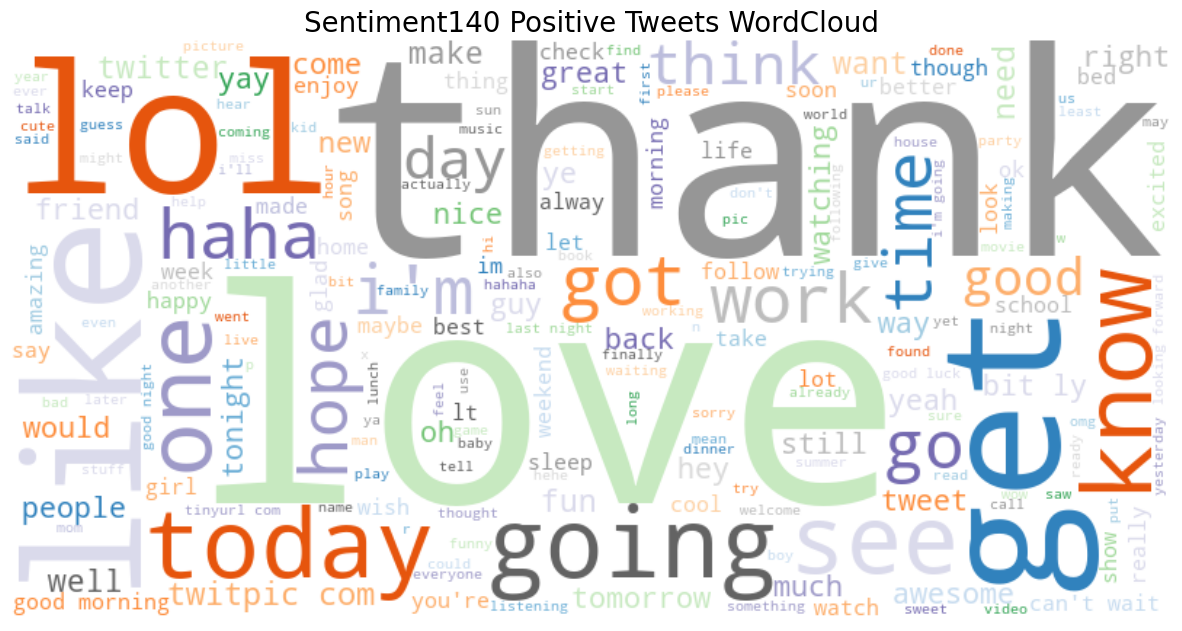

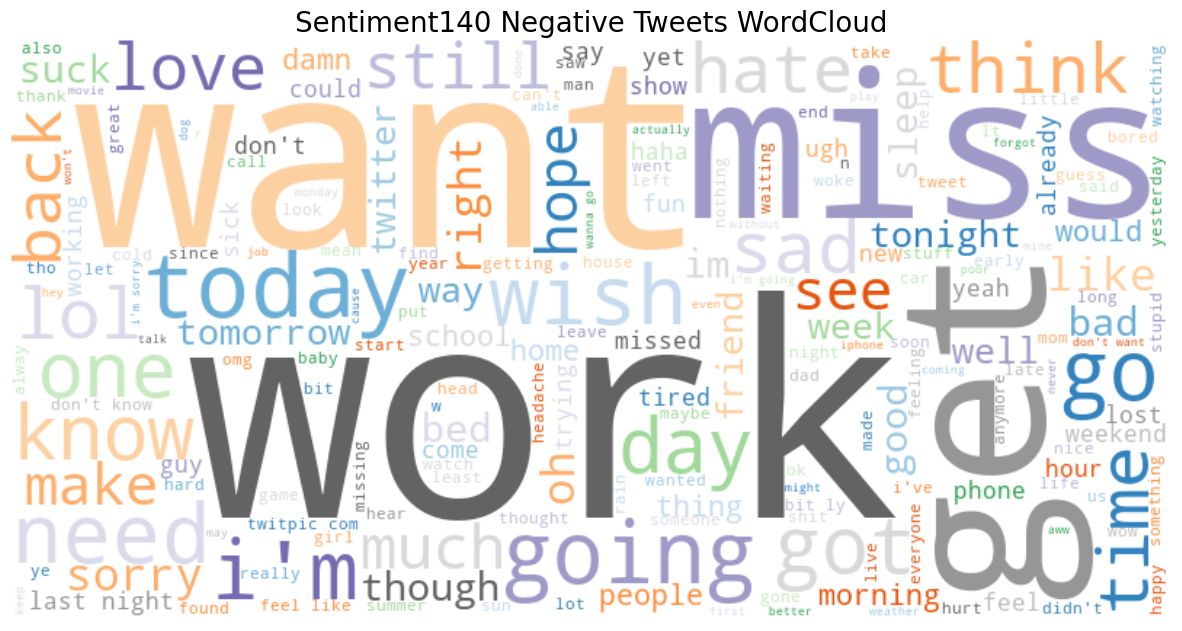

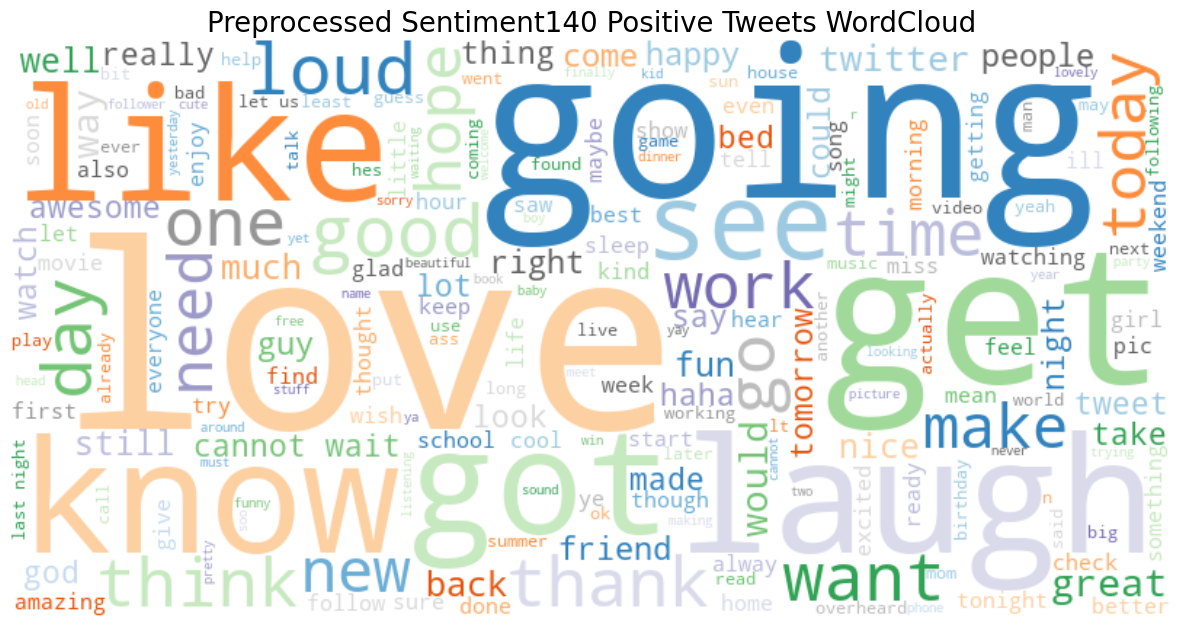

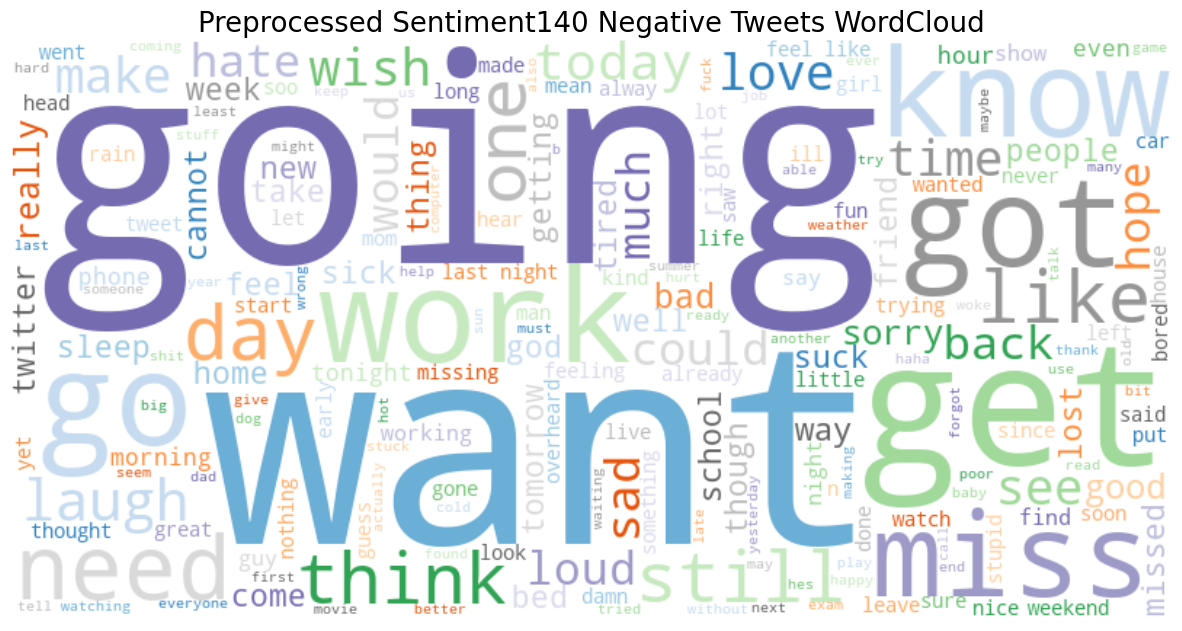

In [25]:
stops = stopwords.words('english')

def appendStopsNoApostrophes(wordList):
    newList = wordList
    for word in wordList:
        if word.find("'") != -1:
            newList.append(word.replace("'", ""))
            newList.remove(word)
    return newList

htmlStops = list(htmlSymbols.keys())
stops = stops + htmlStops
stops.append("amp")
stops.append("quot")
stops.append("https")
stops.append("http")
stops.append("co")
stops.append("u")
stops = appendStopsNoApostrophes(stops)
STOPWORDS = set(stops)


def tweetsDfToWC(df, dfCollumn, wcTitle, stopwordSet):
    tweets_list = df[dfCollumn].apply(lambda x: str(x).lower()).tolist()
    tweets_string = "".join(tweets_list)
    wc = WordCloud(width=800, height=400, background_color='white', colormap='tab20c', stopwords=stopwordSet).generate(tweets_string)
    plt.figure(figsize = (15,15))
    plt.title(wcTitle, fontsize = 20)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")

sentiment140Positive = sentiment140DfPreprocessor1[sentiment140DfPreprocessor1['label'] == 'positive']
sentiment140Negative = sentiment140DfPreprocessor1[sentiment140DfPreprocessor1['label'] == 'negative']

tweetsDfToWC(sentiment140Positive, "tweet", "Sentiment140 Positive Tweets WordCloud", stops)
tweetsDfToWC(sentiment140Negative, "tweet", "Sentiment140 Negative Tweets WordCloud", stops)
tweetsDfToWC(sentiment140Positive, "preprocessor1", "Preprocessed Sentiment140 Positive Tweets WordCloud", stops)
tweetsDfToWC(sentiment140Negative, "preprocessor1", "Preprocessed Sentiment140 Negative Tweets WordCloud", stops)


Methods to evaluate model

In [11]:
# source: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def evaluateModel(modelName, svcModel, xTest, yTest):
    y_pred = svcModel.predict(xTest)
    print(classification_report(yTest, y_pred))
    cf_matrix = confusion_matrix(yTest, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Negative','False Positive', 'False Negative','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '', xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title (modelName + " Confusion Matrix", fontdict = {'size':18}, pad = 20)

# source: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
def showROCCurve(modelName, svcModel, xTest, yTest):
    Y_pred1 = svcModel.predict(xTest)
    fpr, tpr, thresholds = roc_curve(yTest, Y_pred1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkred', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(modelName + ' ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

def trainAndTestSVC(columnString, testSize, randomState, vectoriser, modelName):
    X_train,X_test,Y_train, Y_test = train_test_split(sentiment140DfPreprocessor1[columnString].apply(lambda x: np.str_(x)), 
    sentiment140DfPreprocessor1['sentimentScore'], test_size=testSize, random_state=randomState)  
    # ngram_range required is tuple e.g. (1,1) or (1,2)
    # ngram_range 1,1 means only unigrams are considered, 1,2 unigrams and bigrams
    # Transforming Xtrain and Xtest data using TF-IDF
    vectoriser = vectoriser
    vectoriser.fit_transform(X_train)
    print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))
    X_train = vectoriser.transform(X_train)
    X_test  = vectoriser.transform(X_test)
    print("X_train shape: ", X_train.shape)
    print("Y_train shape: ", Y_train.shape)
    print("X_test shape: ", X_test.shape)
    print("Y_test shape: ", Y_test.shape)
    # Training SVM (LinearSVC) model
    svcModel = LinearSVC()
    svcModel.fit(X_train, Y_train)
    # evaluating model
    evaluateModel(modelName, svcModel, X_test, Y_test)
    showROCCurve(modelName, svcModel, X_test, Y_test)


              precision    recall  f1-score   support

           0       0.83      0.81      0.82    159494
           1       0.81      0.84      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



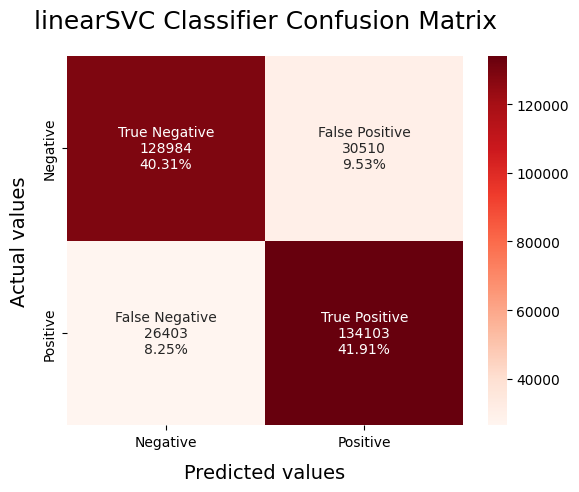

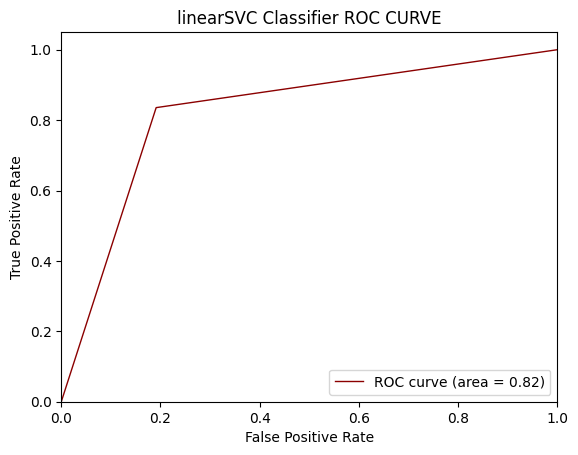

In [12]:
X_train,X_test,Y_train, Y_test = train_test_split(sentiment140DfPreprocessor1["preprocessor1"].apply(lambda x: np.str_(x)), 
sentiment140DfPreprocessor1['sentimentScore'], test_size=0.2, random_state=42)  
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
vectoriser.fit_transform(X_train)
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
linearSVCClassifier = LinearSVC(C=0.1, loss='squared_hinge')
linearSVCClassifier.fit(X_train, Y_train)
evaluateModel("linearSVC Classifier", linearSVCClassifier, X_test, Y_test)
showROCCurve("linearSVC Classifier", linearSVCClassifier, X_test, Y_test)

In [13]:
def preprocessAndPredictSentiment(rawTweet, vectoriserTFIDF, svmModel, preprocessorMethod):
    preprocessedTweet = [preprocessorMethod(rawTweet)]
    tweet = vectoriserTFIDF.transform(preprocessedTweet)
    sentiment = svmModel.predict(tweet)[0]
    if sentiment == 0:
        return "negative"
    else:
        return "positive"

In [14]:


text = "You are all a bunch of idiots, i hate you"
sentiment = preprocessAndPredictSentiment(text, vectoriser, linearSVCClassifier, preprocessor1)
print(sentiment)
text2 = "i love you everything is fantastic"
sentiment2 = preprocessAndPredictSentiment(text2, vectoriser, linearSVCClassifier, preprocessor1)
print(sentiment2)
text3 = ":("
sentiment3 = preprocessAndPredictSentiment(text3, vectoriser, linearSVCClassifier, preprocessor1)
print(sentiment3)
text4 = "happy"
sentiment4 = preprocessAndPredictSentiment(text4, vectoriser, linearSVCClassifier, preprocessor1)
print(sentiment4)


negative
positive
negative
positive


In [15]:
tweetsDf = pd.read_csv("twitterDataOutput.csv")
tweetsDf.head

<bound method NDFrame.head of                             date                   id  \
0       2022-05-31T23:14:24.000Z  1531776135083720711   
1       2022-05-31T22:17:29.000Z  1531761813922136065   
2       2022-05-31T22:09:18.000Z  1531759753071845376   
3       2022-05-31T22:05:43.000Z  1531758850273050626   
4       2022-05-31T22:04:05.000Z  1531758441521467395   
...                          ...                  ...   
448735  2019-01-01T00:20:15.000Z  1079895037868232704   
448736  2019-01-01T00:19:16.000Z  1079894793583509507   
448737  2019-01-01T00:18:55.000Z  1079894704504913920   
448738  2019-01-01T00:16:20.000Z  1079894051745382410   
448739  2019-01-01T00:14:27.000Z  1079893578829230081   

                                                    tweet  
0       @FilipinoFollies It’s outdated. 3rd has negati...  
1       A Japan song title feeling very topical at the...  
2       @FurnaceFear @Jo_dB Although it cuts off befor...  
3       #Bradford is trending on @Twitter!   

In [16]:
tweetsDf['label'] = tweetsDf['tweet'].apply(lambda x: preprocessAndPredictSentiment(x, vectoriser, linearSVCClassifier, preprocessor1))
positiveTweets = tweetsDf[tweetsDf['label'] == "positive"]
negativeTweets = tweetsDf[tweetsDf['label'] == "negative"]
print("number of positive tweets: " + str(positiveTweets.shape[0]))
print("number of negative tweets: " + str(negativeTweets.shape[0]))


number of positive tweets: 295730
number of negative tweets: 153010


In [17]:
tweetsDf.to_csv("twitterDataOutputLabelledLinearSVC.csv", index=False)

In [2]:
tweetsDf = pd.read_csv("twitterDataOutputLabelledLinearSVC.csv")

[Text(0.5, 1.0, 'Positive vs negative UK-based Asia-related tweets Jan 2019 - Jun 2022')]

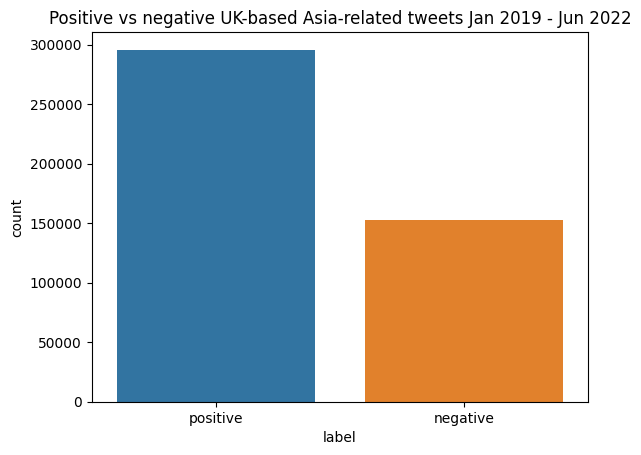

In [9]:
sns.countplot(x=tweetsDf['label'], label= 'count').set(title='Positive vs negative UK-based Asia-related tweets Jan 2019 - Jun 2022')

In [3]:
def floorDate(dateString):
    shortDateStr = dateString[:10]
    shortDateFormat = "%Y-%m-%d"
    return datetime.strptime(shortDateStr, shortDateFormat)

tweetsDf['day'] = tweetsDf['date'].apply(lambda x: floorDate(x))

aggregate = {'cnt': ('id', 'count')}
sentimentOverTimeDf = tweetsDf.groupby(['day', 'label']).agg(**aggregate).reset_index()
sentimentOverTimeDf

fig = px.line(sentimentOverTimeDf, x='day', y='cnt', color='label', title = "SVM sentiment analysis of UK-based Asia-related tweets Jan 2019 - Jun 2022", width=1800, height=600,

labels={
                     "day": "Date",
                     "cnt": "Number of tweets"
                 },
             color_discrete_map={ # replaces default color mapping by value
                "negative":  '#EF553B', "positive": '#00CC96'
            }
)
           
fig.update_layout(font = dict(size = 22))
fig.show()

**Negative tweets as a percentage of total Tweets**

In [20]:
# creating new df 
negativeSentimentProportionDf = tweetsDf.groupby(['day']).agg(**aggregate).reset_index()
negativeSentimentProportionDf.rename(columns={'cnt': 'totalTweetsCnt'}, inplace=True)

def getSentimentLabelCount(day, sentimentStr):
    #day is a date string corresponding to format: 2019-01-01
    subDf = sentimentOverTimeDf.loc[(sentimentOverTimeDf['day'] == day) & (sentimentOverTimeDf['label'] == sentimentStr)]
    # return subDf.iloc[0]['totalTweetsCnt']
    return subDf.iloc[0]['cnt']

negativeSentimentProportionDf['negativeCnt'] = negativeSentimentProportionDf['day'].apply(lambda x: getSentimentLabelCount(x, "negative"))
negativeSentimentProportionDf['percentNegative'] = (negativeSentimentProportionDf["negativeCnt"] / negativeSentimentProportionDf["totalTweetsCnt"]) * 100
negativeSentimentProportionDf.head()

,day,totalTweetsCnt,negativeCnt,percentNegative
0,2019-01-01,420,142,33.809524
1,2019-01-02,473,148,31.289641
2,2019-01-03,633,200,31.595577
3,2019-01-04,478,158,33.054393
4,2019-01-05,421,118,28.028504


In [21]:
fig = px.line(negativeSentimentProportionDf, x='day', y='percentNegative', title = "SVM (LinearSVC) sentiment analysis: negative tweets as a percentage of total Tweets collected", width=1800, height=600,

labels={
                     "day": "Date",
                     "percentNegative": "Percentage of Tweets that are Negative"
                 }
)

fig.update_traces(line_color='red')
fig.update_layout(font = dict(size = 22))
           
fig.show()

In [22]:
negativeSentimentProportionDf['week'] = pd.to_datetime(negativeSentimentProportionDf["day"]).dt.to_period('W-SUN').dt.start_time
negativeSentimentProportionDf.head(20)


,day,totalTweetsCnt,negativeCnt,percentNegative,week
0,2019-01-01,420,142,33.809524,2018-12-31
1,2019-01-02,473,148,31.289641,2018-12-31
2,2019-01-03,633,200,31.595577,2018-12-31
3,2019-01-04,478,158,33.054393,2018-12-31
4,2019-01-05,421,118,28.028504,2018-12-31
5,2019-01-06,412,128,31.067961,2018-12-31
6,2019-01-07,369,108,29.268293,2019-01-07
7,2019-01-08,404,128,31.683168,2019-01-07
8,2019-01-09,370,121,32.702703,2019-01-07
9,2019-01-10,601,235,39.101498,2019-01-07


In [23]:
weekAvgNegativeSentimentProportionDf = negativeSentimentProportionDf.groupby("week").percentNegative.agg('mean').reset_index()
weekAvgNegativeSentimentProportionDf.head()

,week,percentNegative
0,2018-12-31,31.474267
1,2019-01-07,32.212842
2,2019-01-14,29.234850
3,2019-01-21,32.424135
4,2019-01-28,28.277588


In [24]:
fig = px.line(weekAvgNegativeSentimentProportionDf, x='week', y='percentNegative', title = "SVM (LinearSVC) sentiment analysis: negative tweets as a percentage of total Tweets collected per week", width=1800, height=600,

labels={
                     "week": "Date",
                     "percentNegative": "Percentage of Tweets that are Negative"
                 }
)

fig.update_traces(line_color='red')
fig.update_layout(font = dict(size = 22))
           
fig.show()

In [25]:
negativeSentimentProportionDf['month'] = pd.to_datetime(negativeSentimentProportionDf["day"]).dt.to_period('M').dt.start_time
monthAvgNegativeSentimentProportionDf = negativeSentimentProportionDf.groupby("month").percentNegative.agg('mean').reset_index()
fig = px.line(monthAvgNegativeSentimentProportionDf, x='month', y='percentNegative', title = "SVM (LinearSVC) sentiment analysis: negative tweets as a percentage of total Tweets collected per month", width=1800, height=600,

labels={
                     "month": "Date",
                     "percentNegative": "Percentage of Tweets that are Negative"
                 }
)

fig.update_traces(line_color='red')
fig.update_layout(font = dict(size = 22))         
fig.show()

In [ ]:
twitterDataPositive = tweetsDf[tweetsDf['label'] == 'positive']
twitterDataNegative = tweetsDf[tweetsDf['label'] == 'negative']

tweetsDfToWC(twitterDataPositive, "tweet", "UK-based Asia-related tweets Jan 2019 - Jun 2022: Positive Tweets WordCloud", stops)
tweetsDfToWC(twitterDataNegative, "tweet", "UK-based Asia-related tweets Jan 2019 - Jun 2022: Negative Tweets WordCloud", stops)